Python interface for ISPACK3

Copyright (C) 2023--2024 Toshiki Matsushima <toshiki@gfd-dennou.org>

This library is free software; you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation; either version 2.1 of the License, or (at your option) any later version.

This library is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License along with this library; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.


An Application of spherical harmonics expansions (ISPACK for python) in jupyter Lab

* Author: Toshiki Matsushima

## Two-dimensional Decaying Turbulence on a Rotating Sphere

* Referece: Keiichi Ishioka, Michio Yamada, Yoshi-Yuki Hayashi, Shigeo Yoden, 1999: Pattern Formation from Two-dimensional Decaying Turbulence on a Rotating Sphere, Nagare Multimedia (url: https://www2.nagare.or.jp/mm/99/ishioka/index.htm)


$$
\frac{\partial \zeta}{\partial t} + \left( \frac{\partial \psi}{\partial \lambda}\frac{\partial \zeta}{\partial \mu} - \frac{\partial \psi}{\partial \mu}\frac{\partial \zeta}{\partial \lambda} \right) + 2\Omega\frac{\partial \psi}{\partial \lambda} = (-1)^{p+1}\nu_{2p} (\Delta + 2)^p \zeta
$$

Here, $\psi (\lambda, \mu, t)$: stream functions; $ \zeta(\lambda, \mu, t)$: vertical component of vorticity $(\equiv \Delta \psi)$; $\lambda$: longitude; $\mu$: sine latitude; $t$: time; $\Omega$: angular speed of rotation of sphere; $\nu_{2p}$: hyper-viscosity coefficient, and $p$: order of hyper-viscosity. Furthermore, $\Delta$ is the horizontal Laplacian and is defined as follows. 

$$
\Delta \equiv \frac{1}{1-\mu^2}\frac{\partial^2}{\partial \lambda^2} + \frac{\partial}{\partial \mu}\left\{ (1-\mu^2)\frac{\partial}{\partial \mu} \right\}
$$


In [11]:
%matplotlib widget

In [12]:
import os
import numpy as np
import ispack3 as isp
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [13]:

# wrapper class for ispack
class SpectralTransformer:
    def __init__(self, mm=31, nm=31, nt=31, im=64, jm=32, ig=1, num_threads=1):
        
        self.mm = mm
        self.nm = nm
        self.im = im
        self.jm = jm
        self.ig = ig

        self.it, self.t, self.r = isp.sxini1(self.mm, self.nm, self.im)
        self.p, self.jc = isp.sxini2(self.mm, self.nm, self.jm, self.ig, self.r)

        self.nt = nt
        self.C = isp.sxinic(self.mm, self.nt)
        self.D = isp.sxinid(self.mm, self.nt)

        w_shape = (jm*im)
        self.w = isp.aligned_array(w_shape, dtype=np.float64, align=64)        

        isp.mxsomp(num_threads)

    def get_lat(self):
        
        half_jm = self.jm // 2
        second_half_lat = np.arcsin(self.p[0, :half_jm])
        first_half_lat = -second_half_lat[::-1]
        
        return np.concatenate([first_half_lat, second_half_lat])

    def get_lon(self):
        
        return np.linspace(0, 2*np.pi, self.im, endpoint=False)

    def get_coords(self):
        
        lat = self.get_lat()
        lon = self.get_lon()
        
        return lat.reshape(-1,1), lon.reshape(1,-1)
    
    def get_wn(self, nn):
        
        s_shape = ((2*nn+1-self.mm)*self.mm+nn+1,)
        l = np.arange(s_shape[0])
        
        return isp.sxl2nm(nn, l)

    def spectra_shape(self, nn):

        return (nn + 1 + self.mm * (2 * nn - self.mm + 1), )

    def init_array(self, type, nn=None):

        if(type=="grid"):
            arr = isp.aligned_array((jm,im), dtype=np.float64, align=64)

        elif(type=="spectra"):
            arr = np.zeros(self.spectra_shape(nn))
            
        return arr
    
    def to_grid(self, s, G, nn):

        ipow = 0
        isp.sxts2g(self.mm, self.nm, nn, self.im, self.jm, s, G, self.it, self.t, self.p, self.r, self.jc, self.w, ipow)
        
        return
        
    def to_spectra(self, G, s, nn):

        ipow = 0        
        isp.sxtg2s(self.mm, self.nm, nn, self.im, self.jm, s, G, self.it, self.t, self.p, self.r, self.jc, self.w, ipow)
        
        return

    def laplacian(self, s, sl, nt,inverse=False):
        
        iflag = 2 if inverse else 1
        isp.sxclap(self.mm, nt, s, sl, self.D, iflag)
        
        return

    def lon_diff(self, s, sx, nt):

        isp.sxcs2x(self.mm, nt, s, sx)
            
        return

    def coslat_lat_diff(self, s, ST, nt, forward=False):

        if(not forward):        
            isp.sxcs2y(self.mm, nt, s, ST, self.C)

        else:
            isp.sxcy2s(self.mm, nt, s, ST, self.C)

        return


In [14]:
# setting for parallelization
num_threads=32
os.environ["OMP_NUM_THREADS"] = str(num_threads)

In [15]:
# Initialize spherical harmonics class 
# Truncation wavenumber
#mm=682
#nm=683
#im=2048
#jm=1024
mm=341
nm=342
im=1024
jm=512
nt = mm
spt        = SpectralTransformer(mm=mm, nm=nm, nt=nt, im=im, jm=jm, ig=1, num_threads=num_threads)
lats, lons = spt.get_coords()
n,m        = spt.get_wn(nt)

In [16]:

# initial condition

## parameter

n0 = 100
gamma = 1000
np.random.seed(0)

## 

s_Zeta = spt.init_array(type="spectra", nn=nt)
s_Psi = np.zeros_like(s_Zeta)

R = np.zeros_like(s_Zeta)
R = np.random.rand(*R.shape)

# uniform random number within a circle with radius 1
R[m==0] = np.sqrt(R[m==0]) # for amplitude
R[m>0] = np.sqrt(R[m>0]) # for amplitude
R[m<0] = 2*np.pi*R[m<0] # for phase

s_Psi[m==0] = R[m==0]
s_Psi[m>0] = R[m>0] * np.cos(R[m<0])
s_Psi[m<0] = R[m>0] * np.sin(R[m<0])
s_Psi[n<2] = 0 # for conservation of total anuglar momentum

def energy_spectrum_density(s_Psi):
    # energy spectrum density
    Engs = np.zeros_like(s_Psi, dtype=np.float64)
    Engs[(m == 0) & (n >= 0)] = s_Psi[(m == 0) & (n >= 0)]**2
    Engs[(m > 0) & (n >= 0)] = 2 * ( ( s_Psi[(m > 0) & (n >= 0)] )**2 + ( s_Psi[(m < 0) & (n >= 0)] )**2 )
    Engs = Engs * 0.5 * n*(n+1)
    
    return Engs

Engs = energy_spectrum_density(s_Psi)
    
# sum over n
unique_ns = np.arange(nm)
total_contribution_per_n = np.zeros_like(unique_ns, dtype=np.float64)

total_contribution_per_n[0:2] = 0
for unique_n in unique_ns[2:]:
    total_contribution_per_n[unique_n] = np.sum(Engs[n == unique_n]) / len(Engs[n == unique_n])

# reference energy spectrum distribution
eng_dist = np.zeros_like(unique_ns, dtype=np.float64)

#n0 = 100
#gamma = 1000

eng_dist[2:] = 1
for g in range(gamma):
    eng_dist = eng_dist * np.sqrt(unique_ns) / (unique_ns + n0)        
    eng_dist = eng_dist / np.max(eng_dist)

# factorization
for unique_n in unique_ns[2:]:
    s_Psi[n==unique_n] = s_Psi[n==unique_n] * np.sqrt(eng_dist[unique_n]/total_contribution_per_n[unique_n])
    
Engs = energy_spectrum_density(s_Psi)
s_Psi = s_Psi / np.sqrt(np.sum(Engs))

# check
Engs = energy_spectrum_density(s_Psi)

total_contribution_per_n[0:2] = 0
for unique_n in unique_ns[2:]:
    total_contribution_per_n[unique_n] = np.sum(Engs[n == unique_n])

initial_eng_spectrum = np.copy(total_contribution_per_n)
    
#print(np.sum(Engs)) # ==1

nt = mm
spt.laplacian(s_Psi, s_Zeta, nt,inverse=False)

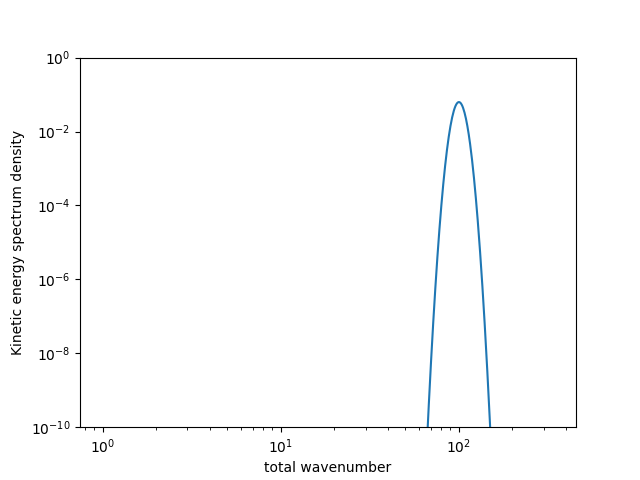

In [17]:

# check initial condition

fig=plt.figure()
plt.plot(unique_ns, initial_eng_spectrum)

plt.ylim(10**(-10), 10**0)

plt.xlabel("total wavenumber")
plt.ylabel("Kinetic energy spectrum density")

plt.xscale("log")
plt.yscale("log")
plt.show()


In [18]:
# parameters

# corioris parameter
omg = 400

dt = 10**(-3)
nu = 10**(-38)
#dt=5*10**(-4)
#nu = 10**(-43)


In [19]:
current_time = 0

# resolvent matrix dt/2
p=8
L_hdt = np.exp(nu*(2*np.mod(p,2)-1)*(-n*(n+1.0)+2)**p *0.5*dt)

inv_coslat2 = 1.0/np.cos(lats)**2

s_Psi                = spt.init_array( type="spectra", nn=nt )

s_dPsi_dlon          = spt.init_array( type="spectra" ,nn=nt   )
s_coslat_dPsi_dlat   = spt.init_array( type="spectra" ,nn=nt+1 )
s_dZeta_dlon         = spt.init_array( type="spectra" ,nn=nt   )
s_coslat_dZeta_dlat  = spt.init_array( type="spectra" ,nn=nt+1 )

dPsi_dlon            = spt.init_array( type="grid" )
coslat_dPsi_dlat     = spt.init_array( type="grid" )
dZeta_dlon           = spt.init_array( type="grid" )
coslat_dZeta_dlat    = spt.init_array( type="grid" )

Zeta                 = spt.init_array( type="grid" )
Nonlinear_term       = spt.init_array( type="grid" )

s_Tendency           = spt.init_array( type="spectra", nn=nt )

def tendency( s_Zeta, s_Tendency ):

    spt.laplacian       ( s_Zeta, s_Psi               , nt, inverse=True )

    spt.lon_diff        ( s_Psi , s_dPsi_dlon         , nt )
    spt.coslat_lat_diff ( s_Psi , s_coslat_dPsi_dlat  , nt )
    spt.lon_diff        ( s_Zeta, s_dZeta_dlon        , nt )
    spt.coslat_lat_diff ( s_Zeta, s_coslat_dZeta_dlat , nt )
    
    spt.to_grid( s_dPsi_dlon        , dPsi_dlon         , nn=nt   )
    spt.to_grid( s_coslat_dPsi_dlat , coslat_dPsi_dlat  , nn=nt+1 )
    spt.to_grid( s_dZeta_dlon       , dZeta_dlon        , nn=nt   )
    spt.to_grid( s_coslat_dZeta_dlat, coslat_dZeta_dlat , nn=nt+1 )
        
    Nonlinear_term[:,:] = -( (dPsi_dlon * coslat_dZeta_dlat - coslat_dPsi_dlat * dZeta_dlon) * inv_coslat2 + 2*omg*dPsi_dlon )

    spt.to_spectra( Nonlinear_term, s_Tendency, nn=nt )
    
    return

In [ ]:
%%time

total_steps = 5000
out_interv = 100
output_Data = False

vmin = -60
vmax =  60 

if( output_Data ):
    ncfile = Dataset('turb_onsphere.nc', 'w', format='NETCDF4')
    ncfile.createDimension('time', None)
    ncfile.createDimension('lat', lats.shape[0])
    ncfile.createDimension('lon', lons.shape[1])
    
    times = ncfile.createVariable('time', 'f4', ('time',))
    latitudes = ncfile.createVariable('lat', 'f4', ('lat',))
    longitudes = ncfile.createVariable('lon', 'f4', ('lon',))
    vorticity = ncfile.createVariable('vorticity', 'f4', ('time', 'lat', 'lon',), zlib=True, complevel=2)
    
    times.units = 'seconds since 0001-01-01 00:00:00.0'
    times.calendar = 'gregorian'
    latitudes[:] = lats.reshape(-1)  * 180.0/np.pi
    longitudes[:] = lons.reshape(-1) * 180.0/np.pi

    latitudes.units = 'degrees_north'
    latitudes.long_name = 'latitude'
    longitudes.units = 'degrees_east'
    longitudes.long_name = 'longitude'

k1       = spt.init_array( type="spectra", nn=nt )
k2       = spt.init_array( type="spectra", nn=nt )
k3       = spt.init_array( type="spectra", nn=nt )
k4       = spt.init_array( type="spectra", nn=nt )
s_Zeta_1 = spt.init_array( type="spectra", nn=nt )
s_Zeta_2 = spt.init_array( type="spectra", nn=nt )

plt.ioff()  # turn off interactive mode
fig, axs = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

print("Current time:", current_time)
print("Final target time:", current_time + total_steps * dt)

for step in tqdm(range(total_steps), mininterval=2):
    
    # 4th order Runge Kutta + operate resolvent matrix
    tendency( s_Zeta, k1 )
    
    s_Zeta_1[:] = L_hdt*(s_Zeta+0.5*dt*k1)
    tendency( s_Zeta_1, k2 )

    s_Zeta_2[:] = L_hdt*s_Zeta
    
    s_Zeta_1[:] = s_Zeta_2 + 0.5*dt*k2
    tendency( s_Zeta_1, k3 )
    
    s_Zeta_1[:] = L_hdt*(s_Zeta_2+dt*k3)
    tendency( s_Zeta_1, k4 )

    s_Zeta[:]   = L_hdt*( L_hdt*(s_Zeta+dt*k1/6.0) + dt*(k2+k3)/3.0 ) + dt*k4/6.0
    
    current_time += dt

    if np.mod(step+1, out_interv) == 0:
        spt.to_grid( s_Zeta, Zeta, nn=nt )

        if( output_Data ):
            times[step // out_interv] = current_time
            vorticity[step // out_interv, :, :] = Zeta[:,:]

            ncfile.sync()
        
        axs.set_title(f"Relative Vorticity (T= {current_time:.2f})")
        axs.set_xlabel("Longitude (degrees)")
        axs.set_ylabel("Latitude (degrees)")
        axs.set_xticks(np.linspace(0, 360, 13))
        axs.set_yticks(np.linspace(-90, 90, 7))

        im1 = axs.imshow(Zeta, cmap="jet", vmin=vmin, vmax=vmax, 
                         interpolation="bilinear",
                         extent=[np.min(lons) * 180 / np.pi, np.max(lons) * 180 / np.pi, 
                                 np.min(lats) * 180 / np.pi, np.max(lats) * 180 / np.pi],
                         origin="lower")

        if step+1 == out_interv:
            cbar = fig.colorbar(im1, ax=axs, shrink=0.75, aspect=12)

        fig.savefig(f"vorticity.{step // out_interv:04d}.png")
        axs.clear()

plt.close(fig)
if( output_Data ):
    ncfile.close()

Current time: 0
Final target time: 5.0


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:

fig, axs = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

axs.set_title(f"Relative Vorticity (T= {current_time:.2f})")
axs.set_xlabel("Longitude (degrees)")
axs.set_ylabel("Latitude (degrees)")
axs.set_xticks(np.linspace(0, 360, 13))
axs.set_yticks(np.linspace(-90, 90, 7))

im1 = axs.imshow(Zeta, cmap="jet", vmin=vmin, vmax=vmax, 
                 interpolation="bilinear",
                 extent=[np.min(lons) * 180 / np.pi, np.max(lons) * 180 / np.pi, 
                         np.min(lats) * 180 / np.pi, np.max(lats) * 180 / np.pi],
                 origin="lower")

cbar = fig.colorbar(im1, ax=axs, shrink=0.75, aspect=12)

plt.show()


In [ ]:

spt.laplacian( s_Zeta, s_Psi, nt, inverse=True )

Engs = energy_spectrum_density(s_Psi)

total_contribution_per_n[:] = 0
for unique_n in unique_ns[1:]:
    total_contribution_per_n[unique_n] = np.sum(Engs[n == unique_n])

fig=plt.figure()
plt.plot(unique_ns[2:], initial_eng_spectrum[2:], label="T=0", linestyle="dotted")
plt.plot(unique_ns[2:], total_contribution_per_n[2:], label=f"T={current_time:.3f}")
plt.plot(unique_ns[2:], 50.0/unique_ns[2:]**(3), label="power of -3 curve")

# wave number corresponding to Rhines scale
nb = np.sqrt(np.pi*omg/(4*np.sqrt(2)))
plt.plot([nb,nb], [10**(-10), 10**0])

plt.legend()

plt.ylim(10**(-10), 10**0)

plt.xlabel("total wavenumber")
plt.ylabel("Kinetic energy spectrum density")

plt.xscale("log")
plt.yscale("log")
plt.show()

fig.savefig("eng-spectrum.pdf")
